In [97]:
%load_ext autoreload
%autoreload 2

import torch
import transformers
import pandas as pd 
import text_extensions_for_pandas as tp
from tqdm import tqdm
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader

!ls

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
__pycache__                   model.py
baselines                     new_model.py
data_logical_fallacy          precomputed_bert_models.ipynb
data_proppy                   proppy_transfer.ipynb
data_speeches.csv             pytorch_train.py
dataset.py                    readme.md
dataset_bert.py               results
hwaj_notebook.ipynb           saved_models
inference.ipynb               trainingOutput
ingest_data_test.ipynb


In [11]:
colnames = ['text','event_location','average_tone','article_date','article_ID','article_URL_1','MBFC_factuality_label_1','article_URL','MBFC_factuality_label','URL_to_MBFC_page','source_name','MBFC_notes_about_source','MBFC_bias_label','source_URL','propaganda_label']
proppy_dev = pd.read_csv("data_proppy/proppy_1.0.dev.tsv",sep='\t',names=colnames)[["text",'average_tone','source_name','propaganda_label']]
proppy_dev.head()

,text,average_tone,source_name,propaganda_label
0,Convened to examine the causes of civil unrest...,-4.593640,The Hartford Courant,-1
1,Discriminating against someone on the basis of...,-1.566952,The Hartford Courant,-1
2,"Bill Cosby's 44-year-old daughter, Ensa Cosby,...",-6.150660,The Hartford Courant,-1
3,"The fast-moving, powerful theatrical locomotiv...",1.524390,The Hartford Courant,-1
4,It's Friday. It's National Pizza Day. Grab lif...,1.197605,The Hartford Courant,-1


In [ ]:
bert_model_name = "bert-base-uncased"

tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name, 
                                                           add_special_tokens=True)
bert = transformers.BertModel.from_pretrained(bert_model_name)




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
feats = np.zeros([len(proppy_dev),768])

for i,row in tqdm(proppy_dev.iterrows()): 
    toks = tp.io.bert.make_bert_tokens(proppy_dev.text[i],tokenizer)
    emb_df = tp.io.bert.add_embeddings(toks, bert)
    feats[i,:] = emb_df.embedding.to_numpy().mean(axis=0)
    
    
    

5125it [3:37:40,  2.55s/it]


In [40]:
len(proppy_dev)

5125

In [41]:
feats

array([[-0.07519729,  0.1750659 ,  0.22689338, ..., -0.06930672,
         0.06440458, -0.00516594],
       [-0.10818958,  0.09823903,  0.13773319, ...,  0.04717225,
        -0.00811862,  0.14017554],
       [-0.13764539,  0.02021009,  0.24139456, ...,  0.03524834,
         0.21321787, -0.08245312],
       ...,
       [-0.1374764 ,  0.10403664,  0.13267258, ..., -0.02726575,
         0.19213852,  0.14666592],
       [ 0.05461893,  0.3660191 ,  0.19056308, ..., -0.06918009,
         0.20644763,  0.0774904 ],
       [ 0.05102529,  0.07965963,  0.25242335, ..., -0.09123608,
         0.2235851 ,  0.09679378]])

In [42]:
feats_pt = torch.from_numpy(feats)


In [44]:
torch.save(feats_pt,"results/proppy_dev.pt")

In [294]:
proppy_train = pd.read_csv("data_proppy/proppy_1.0.train.tsv",sep='\t',names=colnames)[["text",'average_tone','source_name','propaganda_label']]
proppy_train.head()

,text,average_tone,source_name,propaganda_label
0,"Et tu, Rhody? A recent editorial in the Provi...",-3.181818,The Hartford Courant,-1
1,A recent post in The Farmington Mirror — our t...,-0.424328,The Hartford Courant,-1
2,"President Donald Trump, as he often does while...",-2.469136,The Hartford Courant,-1
3,"February is Black History Month, and nothing l...",-0.894632,The Hartford Courant,-1
4,"The snow was so heavy, whipped up by gusting w...",-4.800000,The Hartford Courant,-1


In [305]:
ratios = proppy_train[["text","propaganda_label"]].rename(columns={'text':'count'}).groupby("propaganda_label").count()

ratios["perc"] = ratios['count']/ ratios['count'].to_numpy().sum()
ratios

,count,perc
propaganda_label,,
-1,31965,0.888262
1,4021,0.111738


In [47]:
feats_train = np.zeros([len(proppy_train),768])

for i,row in tqdm(proppy_train.iterrows()): 
    toks = tp.io.bert.make_bert_tokens(proppy_train.text[i],tokenizer)
    emb_df = tp.io.bert.add_embeddings(toks, bert)
    feats_train[i,:] = emb_df.embedding.to_numpy().mean(axis=0)

35986it [25:19:36,  2.53s/it]


In [48]:
train_pt = torch.from_numpy(feats_train)
torch.save(train_pt,"results/proppy_train.pt")

In [49]:
proppy_test = pd.read_csv("data_proppy/proppy_1.0.test.tsv",sep='\t',names=colnames)[["text",'average_tone','source_name','propaganda_label']]
proppy_test.head()

,text,average_tone,source_name,propaganda_label
0,Eat in Connecticut teamed up with End Hunger C...,0.781250,The Hartford Courant,-1
1,Owners of an old Pennsylvania power plant that...,-1.615799,The Hartford Courant,-1
2,The majority owner of President Donald Trump's...,-4.177546,The Hartford Courant,-1
3,Connecticut’s most likely option for using tol...,-7.200811,The Hartford Courant,-1
4,Escaped prisoner Jerry Mercado is back in Conn...,-6.534091,The Hartford Courant,-1


In [50]:
feats_test = np.zeros([len(proppy_test),768])

for i,row in tqdm(proppy_test.iterrows()): 
    toks = tp.io.bert.make_bert_tokens(proppy_test.text[i],tokenizer)
    emb_df = tp.io.bert.add_embeddings(toks, bert)
    feats_test[i,:] = emb_df.embedding.to_numpy().mean(axis=0)
    

10159it [6:41:51,  2.37s/it]


In [221]:
test_pt = torch.from_numpy(feats_test)
torch.save(test_pt,"results/proppy_test.pt")

In [63]:
# define funct that does ^ 
def make_emb_vecs(df, tokenizer, bert, out_file_name = None, text_col = "text"): 
    feats = np.zeros([len(df),768])
    for i in tqdm(range(len(df))): 
        toks = tp.io.bert.make_bert_tokens(df.loc[i,text_col],tokenizer)
        emb_df = tp.io.bert.add_embeddings(toks,bert) 
        feats[i,:] = emb_df.embedding.to_numpy().mean(axis=0)
    if out_file_name is not None: 
        torch.save(torch.from_numpy(feats),out_file_name)
    return feats 


In [65]:
train_fal_df = pd.read_csv("data_logical_fallacy/climate_train.csv")
test_fal_df  = pd.read_csv("data_logical_fallacy/climate_test.csv")
dev_fal_df   = pd.read_csv("data_logical_fallacy/climate_dev.csv")
dev_fal_df

,Unnamed: 0,original_url,source_article,logical_fallacies
0,52,https://www.thesun.co.uk/tech/11044576/new-isl...,Rising temperatures in Antarctica over the pas...,false causality
1,1226,https://www.forbes.com/sites/robertbradley/201...,Green activists are at war with the greatest A...,intentional
2,413,https://www.bostonglobe.com/opinion/columns/20...,The list of variables that shape climate inclu...,fallacy of extension
3,1112,http://www.breitbart.com/big-government/2017/0...,What all these papers argue in their different...,intentional
4,559,https://www.forbes.com/sites/jamestaylor/2015/...,The Facts\n\nGlobal warming alarmists ’ prefer...,fallacy of logic
...,...,...,...,...
195,1341,https://www.telegraph.co.uk/news/science/11733...,The earth is 15 years from a period of low sol...,intentional
196,1018,https://www.theatlantic.com/health/archive/201...,To understand why the climate impact of beef a...,fallacy of logic
197,375,http://www.cnn.com/2017/05/29/opinions/withdra...,"And as soon as possible , President Trump shou...",fallacy of extension
198,1165,https://www.telegraph.co.uk/news/2017/05/06/an...,"Inevitably , when even satellite temperatures ...",intentional


In [12]:
fal_train_feats = make_emb_vecs(train_fal_df,tokenizer,bert,"results/climate_train.pt",text_col = "source_article")
fal_dev_feats = make_emb_vecs(dev_fal_df,tokenizer,bert,"results/climate_dev.pt",text_col = "source_article")
fal_test_feats = make_emb_vecs(test_fal_df,tokenizer,bert,"results/climate_test.pt",text_col = "source_article")



NameError: name 'make_emb_vecs' is not defined

In [192]:
# pre-train on
from dataset_bert import FallacyDatasetEmb
from pathlib import Path
data_train = FallacyDatasetEmb(Path("data_logical_fallacy","climate_train.csv"),
                            Path("results","climate_train.pt"),
                            label_header="logical_fallacies")
data_dev = FallacyDatasetEmb(Path("data_logical_fallacy","climate_dev.csv"),
                            Path("results","climate_dev.pt"),
                            label_header="logical_fallacies")
data_test = FallacyDatasetEmb(Path("data_logical_fallacy","climate_test.csv"),
                            Path("results","climate_test.pt"),
                            label_header="logical_fallacies")

In [201]:
from torch.utils.data import DataLoader

fal_train_loader = DataLoader(data_train,batch_size=16,shuffle=True)
fal_dev_loader = DataLoader(data_dev,batch_size=16,shuffle=True)
fal_test_loader = DataLoader(data_test,batch_size=16,shuffle=True)

In [254]:
from collections import Counter
counts = Counter(datum['label'] for datum in data_train)
counts = pd.DataFrame({"Counts":pd.Series(counts)})
counts.index.names= ["label"]
counts['perc'] = counts['Counts']/counts['Counts'].sum()
counts['anti_perc'] = 1/counts['perc']
counts['corr'] = counts.anti_perc/counts.anti_perc.sum()
by_class_corr = counts['corr'].to_numpy()
counts.transpose()

label,0,1,2,3,4,5,6,7,8,9,10,11,12
Counts,79.000000,99.000000,54.000000,243.000000,92.000000,53.000000,49.000000,98.000000,44.000000,39.000000,5.000000,78.000000,18.000000
perc,0.083070,0.104101,0.056782,0.255521,0.096740,0.055731,0.051525,0.103049,0.046267,0.041009,0.005258,0.082019,0.018927
anti_perc,12.037975,9.606061,17.611111,3.913580,10.336957,17.943396,19.408163,9.704082,21.613636,24.384615,190.200000,12.192308,52.833333
corr,0.029961,0.023908,0.043832,0.009740,0.025728,0.044659,0.048305,0.024152,0.053794,0.060691,0.473387,0.030345,0.131496


In [302]:
from torch.optim import AdamW
from new_model import FallacyModel
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score, accuracy_score


device = 'cuda' if torch.cuda.is_available() else 'cpu' 

fmodel = FallacyModel(n_hiddens=20,dropout=0.5).to(device)
optim = AdamW(fmodel.parameters(), lr = 1e-4,weight_decay = 1e-5)
loss_fn = CrossEntropyLoss(weight=torch.from_numpy(by_class_corr).float())

fmodel.train()
train_losses = []
train_accs = []
dev_losses = []
dev_accs = []
test_accs = []

for epoch in (pbar := tqdm(range(200))): 
    preds = []
    labs = []
    losses = [] 
    for batch in fal_train_loader: 
        optim.zero_grad()
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)

        out = fmodel(feats)
        loss = loss_fn(out,labels)
        loss.backward()
        optim.step()
        preds += torch.argmax(out,dim=1).cpu().tolist() 
        labs += batch['label'].tolist()
        losses.append(float(loss.cpu()))
    train_losses.append(sum(losses)/len(losses))
    train_accs.append(accuracy_score(labs,preds))
    # test model on dev set 
    fmodel.eval()
    dev_los_acc = []
    dev_preds = []
    dev_labels = []
    for batch in fal_dev_loader: 
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)

        out = fmodel(feats)
        loss = loss_fn(out,labels)
        dev_preds += torch.argmax(out,dim=1).cpu().tolist() 
        dev_labels += batch['label'].tolist()
        dev_los_acc.append(float(loss.cpu()))
    dev_losses.append(sum(dev_los_acc)/len(dev_los_acc))
    dev_accs.append(accuracy_score(dev_labels,dev_preds))
    
    test_los_acc = []
    test_preds = []
    test_labels = []
    for batch in fal_test_loader: 
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)

        out = fmodel(feats)
        loss = loss_fn(out,labels)
        test_preds += torch.argmax(out,dim=1).cpu().tolist() 
        test_labels += batch['label'].tolist()
        test_los_acc.append(float(loss.cpu()))
    test_accs.append(accuracy_score(test_labels,test_preds))

    pbar.set_description(f'dev acc: {dev_accs[-1]}')

    fmodel.train()
    # print(f'at epoch {epoch}, train L: {train_losses[-1]}, Dev L: {dev_losses[-1]}') 
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.43it/s]


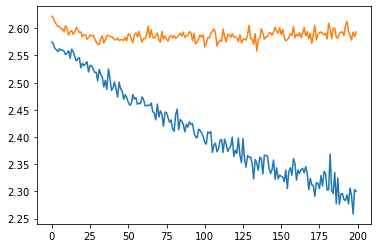

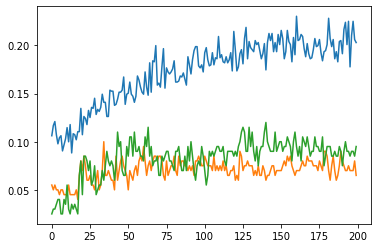

In [306]:
from matplotlib import pyplot as plt 

plt.plot(list(range(len(train_losses))),train_losses)
plt.plot(list(range(len(train_losses))),dev_losses)

plt.figure()
plt.plot(list(range(len(train_losses))),train_accs)
plt.plot(list(range(len(train_losses))),dev_accs)
plt.plot(list(range(len(train_losses))),test_accs)


In [312]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score

def calc_stats(preds,labs,average='weighted'):
    stats = {}
    prec = precision_score(labs,preds,average=average)
    recall = recall_score(labs,preds,average=average)
    acc = accuracy_score(labs,preds)
    stats['f1'] = 2*(prec * recall)/(prec +recall)
    stats['precision'] = prec 
    stats['recall'] = recall
    stats['accuracy']= acc
    return stats
stats = {}
stats['train'] = calc_stats(preds,labs)
stats['dev'] = calc_stats(dev_preds,dev_labels)
stats['test'] = calc_stats(test_preds,test_labels)
pd.DataFrame(stats)

/Users/zachary/opt/anaconda3/envs/eecs_nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zachary/opt/anaconda3/envs/eecs_nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,train,dev,test
f1,0.933233,0.942186,0.114731
precision,0.939438,0.946260,0.144807
recall,0.927111,0.938146,0.095000
accuracy,0.927111,0.938146,0.095000


In [177]:
float(loss.cpu())

0.5724276900291443

In [2]:
# create datasets
from pathlib import Path
from dataset_bert import ProppyDatasetEmb
proppy_train_set = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.train.tsv"),embspath="results/proppy_train.pt")
proppy_dev_set = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.dev.tsv"),embspath="results/proppy_dev.pt")
proppy_test_set = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.test.tsv"),embspath="results/proppy_test.pt")



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [4]:
from torch.utils.data import DataLoader
prop_train_loader = DataLoader(proppy_train_set,batch_size=16,shuffle=True)
prop_dev_loader = DataLoader(proppy_dev_set,batch_size=16,shuffle=True)


In [5]:
# train model from  past thing 


In [13]:
import torch
from torch.optim import AdamW
from new_model import FallacyModel
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score, accuracy_score
from new_model import ProppyModel
from tqdm import tqdm


# pmodel = ProppyModel(from_model =fmodel,dropout_p=0.3)
pmodel = ProppyModel(n_hiddens=20)


train_losses = []
train_accs = []
dev_losses = []
dev_accs = []
pos_portion = []

In [14]:
weight_prop = .8
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
optim = AdamW(pmodel.parameters(), lr = 1e-4,weight_decay = 1e-8)
loss_fn = CrossEntropyLoss(weight=torch.Tensor([1-weight_prop,weight_prop]))
dev_loss_fn = CrossEntropyLoss()
pmodel.train()



for epoch in (bar:= tqdm(range(400)) ): 
    preds = []
    labs = []
    losses = [] 
    for batch in prop_train_loader: 
        optim.zero_grad()
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)
        

        out = pmodel(feats)
        loss = loss_fn(out,labels)
        loss.backward()
        optim.step()
        preds += torch.argmax(out,dim=1).cpu().tolist() 
        labs += batch['label'].tolist()
        losses.append(float(loss.cpu()))
    train_losses.append(sum(losses)/len(losses))
    train_accs.append(accuracy_score(labs,preds))
    # test model on dev set 
    pmodel.eval()
    dev_los_acc = []
    dev_preds = []
    dev_labels = []
    for batch in prop_dev_loader: 
        labels = batch['label'].to(device)
        feats = batch['feats'].to(device)

        out = pmodel(feats)
        loss = loss_fn(out,labels)
        dev_preds += torch.argmax(out,dim=1).cpu().tolist() 
        dev_labels += batch['label'].tolist()
        dev_los_acc.append(float(loss.cpu()))
    dev_losses.append(sum(dev_los_acc)/len(dev_los_acc))
    dev_accs.append(accuracy_score(dev_labels,dev_preds))
    pos_portion.append(sum(dev_preds)/len(dev_preds))
    pmodel.train()
    bar.set_description(f'dev acc: {dev_accs[-1]}')
    # print(f'at epoch {epoch}, train L: {train_losses[-1]}, Dev L: {dev_losses[-1]}') 
    

dev acc: 0.9293658536585366: 100%|██████████████████████████████████████████████████████████████████| 400/400 [22:14<00:00,  3.34s/it]


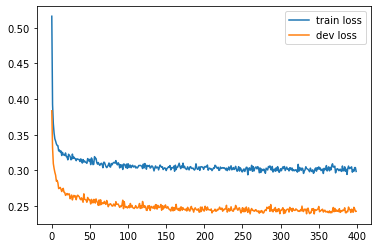

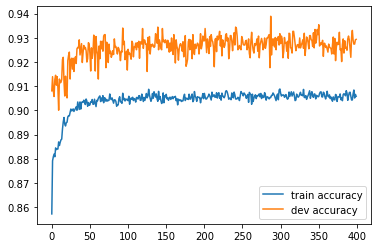

In [15]:
from matplotlib import pyplot as plt 

plt.plot(list(range(len(train_losses))),train_losses)
plt.plot(list(range(len(train_losses))),dev_losses)
plt.legend(['train loss','dev loss'])

plt.figure()
plt.plot(list(range(len(train_losses))),train_accs)
plt.plot(list(range(len(train_losses))),dev_accs)
plt.legend(['train accuracy','dev accuracy'])


In [16]:
dev_accs[-1]

0.9293658536585366

In [326]:
torch.save(pmodel,"results/basic_400_ac.9293.pt")

# Test models on balanced dataset 

In [17]:
# balanced datasets  
from sklearn.metrics import precision_recall_fscore_support


balanced_ds = {}
balanced_ds['train'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.train.tsv")
                                        ,embspath="results/proppy_train.pt",balance=True)
balanced_ds['dev'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.dev.tsv")
                                         ,embspath="results/proppy_dev.pt",balance=True)
balanced_ds['test'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.test.tsv")
                                        ,embspath="results/proppy_test.pt",balance=True)  


unbalanced_ds = {}
unbalanced_ds['train'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.train.tsv")
                                        ,embspath="results/proppy_train.pt",balance=False)
unbalanced_ds['dev'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.dev.tsv")
                                         ,embspath="results/proppy_dev.pt",balance=False)
unbalanced_ds['test'] = ProppyDatasetEmb(filepath=Path("data_proppy/proppy_1.0.test.tsv")
                                        ,embspath="results/proppy_test.pt",balance=False)    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [167]:
# print out the counts in balanced train,dev,test folds
counts_types = {}
for name,ds in balanced_ds.items(): 
    counts_dict = {"positive":0, "negative":0}
    for i in range(len(ds)):
        counts_dict["positive"] += int(ds[i]['label'] == 1)
        counts_dict["negative"] += int(ds[i]['label'] != 1)
    counts_types[name] = counts_dict
pd.DataFrame(counts_types)

,train,dev,test
positive,4021,575,1140
negative,3930,563,1128


In [332]:
from sklearn.metrics import confusion_matrix


def get_stats(model,datasets):
    outputs = {}
    for name,ds in datasets.items(): 
        loader = DataLoader(ds,batch_size=32) 
        model.eval()
        all_labs = []
        all_preds= [] 
        for batch in loader: 
            labels = batch['label']
            feats = batch['feats']

            outs = model(feats)
            all_preds += torch.argmax(outs,dim=1).tolist() 
            all_labs += labels.tolist()
        cm = confusion_matrix(all_labs,all_preds)
        tp,fn,fp,tn  = cm[0][0], cm[0][1], cm[1][0],cm[1][1]
        stats = {}
        prec = tp/(tp+fp)
        recall = tp/(tp+fn)
        stats['f1'] = 2*(prec * recall)/(prec +recall)
        stats['precision'] = prec 
        stats['recall'] = recall
        stats['accuracy']= (tp + tn)/(tp + tn + fp + fn) 
        outputs[name] = stats 
    return pd.DataFrame(outputs).transpose()

In [333]:
trans_mod_path = "results/transfer_400_acc.940.pt"
trans_model = torch.load(model_path)
print("balanced dataset stats for transfer learning model:")
trans_mod_stats = get_stats(trans_model,balanced_ds)
trans_mod_stats

balanced dataset stats for transfer learning model:


,f1,precision,recall,accuracy
train,0.898467,0.854813,0.946819,0.894227
dev,0.888329,0.842357,0.939609,0.883128
test,0.885353,0.820106,0.961879,0.876102


In [334]:
reg_model_path = "results/basic_model_epoch_800_ac.910.pt"
reg_model = torch.load(reg_model_path)
print("balanced dataset stats for basic model:")
reg_mod_stats = get_stats(reg_model,balanced_ds)
reg_mod_stats

balanced dataset stats for basic model:


,f1,precision,recall,accuracy
train,0.876853,0.845663,0.910433,0.873601
dev,0.868243,0.827697,0.912966,0.862917
test,0.869456,0.823296,0.921099,0.862434


In [335]:
trans_mod_path = "results/transfer_400_acc.940.pt"
trans_model = torch.load(model_path)
print("regular dataset stats for transfer learning model:")
trans_mod_stats = get_stats(trans_model,unbalanced_ds)
trans_mod_stats

regular dataset stats for transfer learning model:


,f1,precision,recall,accuracy
train,0.963496,0.979569,0.947943,0.936197
dev,0.962277,0.977551,0.947473,0.934049
test,0.959127,0.972856,0.945781,0.928438


In [336]:
reg_model_path = "results/basic_model_epoch_800_ac.910.pt"
reg_model = torch.load(reg_model_path)
print("regular dataset stats for basic model:")
reg_mod_stats = get_stats(reg_model,unbalanced_ds)
reg_mod_stats

regular dataset stats for basic model:


,f1,precision,recall,accuracy
train,0.946464,0.978201,0.916721,0.907881
dev,0.947927,0.975134,0.922198,0.910049
test,0.945158,0.973777,0.918173,0.905404


# Test on presidential speeches 
First create bert embeddings of each sentence (treating each speech sentence as its own document), then run inference on each sentence within each document

In [95]:
import csv
import nltk

speech_feats = []
with open('data_speeches.csv', 'r') as file: 
    reader = csv.reader(file) 
    for row in reader: 
        speech_title = row[0]
        speech_author = row[1]
        speech_text = row[2]
        speech_feats.extend([{
            "title": speech_title,
            "speaker": speech_author,
            "text": sent,
            }
            for sent in nltk.sent_tokenize(speech_text)
            ])
speech_df = pd.DataFrame(speech_feats)
speech_df

,title,speaker,text
0,Trump1,Trump,"My fellow Americans, \n\nI want to speak to yo..."
1,Trump1,Trump,"As I have said, the incursion of the US capito..."
2,Trump1,Trump,It angered and appalled millions of Americans ...
3,Trump1,Trump,I want to be very clear.
4,Trump1,Trump,I unequivocally condemn the violence that we s...
...,...,...,...
767,Washington1,Washington,"It concerns myself, and will therefore be as b..."
768,Washington1,Washington,When I was first honoured with a call into the...
769,Washington1,Washington,From this resolution I have in no instance dep...
770,Washington1,Washington,And being still under the impressions which pr...


In [100]:
bert_model_name = "bert-base-uncased"

tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name, 
                                                           add_special_tokens=True)
bert = transformers.BertModel.from_pretrained(bert_model_name)




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [101]:
speech_feats = np.zeros([len(speech_df),768])

for i,row in tqdm(speech_df.iterrows()): 
    toks = tp.io.bert.make_bert_tokens(row['text'],tokenizer)
    emb_df = tp.io.bert.add_embeddings(toks, bert)
    speech_feats[i,:] = emb_df.embedding.to_numpy().mean(axis=0)

772it [05:22,  2.39it/s]


In [118]:
from torch.nn.functional import softmax
preds = torch.sigmoid(trans_model(torch.from_numpy(speech_feats).float()))
speech_df[['neg_p','pos_p']] = softmax(preds,dim=1).detach().numpy()
speech_df

,title,speaker,text,neg_p,pos_p
0,Trump1,Trump,"My fellow Americans, \n\nI want to speak to yo...",0.704420,0.295580
1,Trump1,Trump,"As I have said, the incursion of the US capito...",0.648197,0.351803
2,Trump1,Trump,It angered and appalled millions of Americans ...,0.424417,0.575583
3,Trump1,Trump,I want to be very clear.,0.680986,0.319014
4,Trump1,Trump,I unequivocally condemn the violence that we s...,0.657644,0.342356
...,...,...,...,...,...
767,Washington1,Washington,"It concerns myself, and will therefore be as b...",0.716648,0.283352
768,Washington1,Washington,When I was first honoured with a call into the...,0.692157,0.307843
769,Washington1,Washington,From this resolution I have in no instance dep...,0.575301,0.424699
770,Washington1,Washington,And being still under the impressions which pr...,0.593235,0.406765


In [132]:
# output top 5 most propagandic statements 
bottom_20 = speech_df.sort_values("neg_p",ascending=False).head(20)
bottom_20.to_csv('results/bottom_20_.csv')
bottom_20


,title,speaker,text,neg_p,pos_p
160,Biden1,Biden,Friends gathered at music clubs and pool halls...,0.730967,0.269033
575,Biden2,Biden,Talk about bullying in schools.,0.730948,0.269052
208,Biden1,Biden,The death toll records by local officials said...,0.730185,0.269815
495,Biden2,Biden,My plan will extend the vaccination requiremen...,0.730095,0.269905
259,Biden1,Biden,Mother Fletcher talks about how she was only a...,0.729856,0.270144
179,Biden1,Biden,Words were exchanged.,0.729544,0.270456
32,Trump1,Trump,"We will get through this challenge, just like ...",0.729413,0.270587
288,Biden1,Biden,"Second, small businesses are the engines of ou...",0.728296,0.271704
670,Biden3,Biden,The Russian government’s borrowing rate spiked...,0.728273,0.271727
159,Biden1,Biden,"At the Dreamland Theatre, a young Black couple...",0.728258,0.271742
